In [1]:
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import torch
import torch.nn as nn
import torch._dynamo

from pina import Condition, LabelTensor
from pina.domain import CartesianDomain
from pina.equation import Equation, FixedValue
from pina.model import FeedForward
from pina.operator import div, grad
from pina.problem import SpatialProblem
from pina.solver.physics_informed_solver import PINN
from pina.trainer import Trainer

torch._dynamo.config.disable = True
torch._dynamo.config.suppress_errors = True
os.environ.setdefault("TORCH_COMPILE_DISABLE", "1")

if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

plt.rcParams.update({
    "figure.figsize": (7, 5),
    "image.origin": "lower",
    "axes.grid": False,
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# --- Geometry parameters (mm) ---
Lx_mm = 12.0
Lz_mm = 12.0

x_min, x_max = -Lx_mm / 2, Lx_mm / 2
z_min, z_max = 0.0, Lz_mm

contact_radius_mm = 0.025  # Tower A contact radius
gauge_radius_mm = 1.5      # Top gauge half-width

Nx = 241
Nz = 241

x = np.linspace(x_min, x_max, Nx)
z = np.linspace(z_min, z_max, Nz)
dx = float(x[1] - x[0])
dz = float(z[1] - z[0])

X, Z = np.meshgrid(x, z, indexing="ij")

print(f"dx = {dx:.4f} mm, dz = {dz:.4f} mm  (grid: {Nx} x-nodes, {Nz} z-nodes)")

dx = 0.0500 mm, dz = 0.0500 mm  (grid: 241 x-nodes, 241 z-nodes)


In [3]:
j_bottom = 0
j_top = Nz - 1

def make_bottom_mask(center_mm: float, half_width_mm: float) -> np.ndarray:
    return np.abs(x - center_mm) <= half_width_mm

electrode_mask = make_bottom_mask(0.0, contact_radius_mm)
gauge_mask = np.abs(x) <= gauge_radius_mm

print(f"Electrode spans {electrode_mask.sum()} nodes on z=0")
print(f"Gauge spans {gauge_mask.sum()} nodes on z={z_max} mm")

Electrode spans 1 nodes on z=0
Gauge spans 61 nodes on z=12.0 mm


In [4]:
def solve_laplace_fd(
    electrode_mask: np.ndarray,
    *,
    phi_electrode: float = 1.0,
    phi_gauge: float = 0.0,
    gauge_mask: np.ndarray = gauge_mask,
    max_iters: int = 8000,
    tol: float = 1e-5,
    verbose: bool = True,
) -> np.ndarray:
    '''Jacobi relaxation for Laplace's equation with mixed BCs.'''
    phi = np.zeros((Nx, Nz), dtype=np.float64)
    electrode_idx = electrode_mask.astype(bool)
    gauge_idx = gauge_mask.astype(bool)

    for it in range(max_iters):
        phi_old = phi.copy()
        phi[1:-1, 1:-1] = 0.25 * (
            phi_old[2:, 1:-1] + phi_old[:-2, 1:-1] +
            phi_old[1:-1, 2:] + phi_old[1:-1, :-2]
        )

        phi[~electrode_idx, j_bottom] = phi[~electrode_idx, j_bottom + 1]
        phi[electrode_idx, j_bottom] = phi_electrode

        phi[~gauge_idx, j_top] = phi[~gauge_idx, j_top - 1]
        phi[gauge_idx, j_top] = phi_gauge

        phi[0, :] = phi[1, :]
        phi[-1, :] = phi[-2, :]

        err = float(np.max(np.abs(phi - phi_old)))
        if verbose and it % 500 == 0:
            print(f"iter {it:5d}, max dphi = {err:.3e}")
        if err < tol:
            if verbose:
                print(f"Converged in {it} iterations (max dphi = {err:.3e})")
            break

    return phi


def compute_field(phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dphi_dx = np.zeros_like(phi)
    dphi_dz = np.zeros_like(phi)

    dphi_dx[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dx)
    dphi_dx[0, :] = (phi[1, :] - phi[0, :]) / dx
    dphi_dx[-1, :] = (phi[-1, :] - phi[-2, :]) / dx

    dphi_dz[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dz)
    dphi_dz[:, 0] = (phi[:, 1] - phi[:, 0]) / dz
    dphi_dz[:, -1] = (phi[:, -1] - phi[:, -2]) / dz

    Ex = -dphi_dx
    Ez = -dphi_dz
    Emag = np.sqrt(Ex**2 + Ez**2)
    return Ex, Ez, Emag


def plot_field_map(
    Emag: np.ndarray,
    Ex: np.ndarray,
    Ez: np.ndarray,
    *,
    title: str,
    electrode_mask: np.ndarray = electrode_mask,
    gauge_mask: np.ndarray = gauge_mask,
    step: int = 6,
    cmap: str = "plasma",
    vmax: Optional[float] = None,
    log_scale: bool = False,
    floor: float = 1e-6,
) -> None:
    Xs = X[::step, ::step]
    Zs = Z[::step, ::step]
    Exs = Ex[::step, ::step]
    Ezs = Ez[::step, ::step]

    vmax = float(vmax) if vmax is not None else float(np.max(Emag) + 1e-12)
    min_positive = float(np.min(Emag[Emag > 0])) if np.any(Emag > 0) else floor
    if log_scale:
        norm = LogNorm(vmin=max(floor, min_positive), vmax=vmax)
        vmin = None
    else:
        norm = None
        vmin = 0.0

    plt.figure(figsize=(7, 5))
    plt.imshow(
        Emag.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        norm=norm,
    )
    plt.colorbar(label='|E| (arb. units)')

    plt.quiver(
        Xs,
        Zs,
        Exs,
        Ezs,
        color="white",
        scale=40 * vmax,
        width=0.002,
    )

    plt.axhline(z_min, color="k", linewidth=0.5)
    plt.axhline(z_max, color="k", linewidth=0.5)

    plt.plot(x[electrode_mask], np.full(electrode_mask.sum(), z_min), "c", lw=3, label="Electrode")
    plt.plot(x[gauge_mask], np.full(gauge_mask.sum(), z_max), "w", lw=3, label="Gauge (phi=0)")

    plt.xlabel("x (mm)")
    plt.ylabel("z (mm)")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
def make_electrode_masks(centers_mm: Sequence[float], half_width_mm: float = contact_radius_mm) -> List[np.ndarray]:
    return [make_bottom_mask(cx, half_width_mm) for cx in centers_mm]


def solve_basis_library(
    centers_mm: Sequence[float],
    *,
    half_width_mm: float = contact_radius_mm,
    phi_drive: float = 1.0,
    solver_kwargs: Optional[Dict] = None,
) -> Tuple[np.ndarray, List[np.ndarray]]:
    solver_kwargs = solver_kwargs or {}
    masks = make_electrode_masks(centers_mm, half_width_mm=half_width_mm)
    bases = []
    for cx, mask in zip(centers_mm, masks):
        print(f"Solving FD basis for electrode at x = {cx} mm")
        bases.append(solve_laplace_fd(mask, phi_electrode=phi_drive, verbose=False, **solver_kwargs))
    return np.stack(bases, axis=0), masks


def combine_bases(currents: Sequence[float], phi_bases: np.ndarray) -> np.ndarray:
    currents = np.asarray(currents, dtype=np.float64).reshape(-1, 1, 1)
    return np.sum(currents * phi_bases, axis=0)

Solving FD basis for electrode at x = -0.4 mm
Solving FD basis for electrode at x = 0.0 mm
Solving FD basis for electrode at x = 0.4 mm


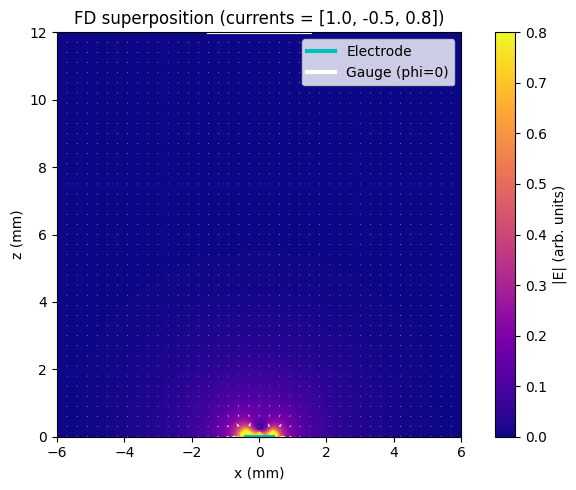

In [6]:
electrode_centers = [-0.4, 0.0, 0.4]
phi_bases_fd, masks_fd = solve_basis_library(electrode_centers)

currents_demo = [1.0, -0.5, 0.8]
phi_combo_fd = combine_bases(currents_demo, phi_bases_fd)
Ex_combo, Ez_combo, Emag_combo = compute_field(phi_combo_fd)

combined_mask = np.any(np.stack(masks_fd, axis=0), axis=0)
plot_field_map(
    Emag_combo,
    Ex_combo,
    Ez_combo,
    title=f"FD superposition (currents = {currents_demo})",
    electrode_mask=combined_mask,
    vmax=0.8,
)

In [7]:
@dataclass(frozen=True)
class TowerA2DGeometry:
    x_bounds: Tuple[float, float] = (x_min, x_max)
    z_bounds: Tuple[float, float] = (z_min, z_max)
    electrode_center_mm: float = 0.0
    contact_halfwidth_mm: float = contact_radius_mm
    gauge_center_mm: float = 0.0
    gauge_halfwidth_mm: float = gauge_radius_mm

    def _clip_interval(self, center: float, half_width: float) -> Tuple[float, float]:
        lo = max(self.x_bounds[0], center - half_width)
        hi = min(self.x_bounds[1], center + half_width)
        if hi <= lo:
            raise ValueError("Interval collapsed; widen the half-width.")
        return float(lo), float(hi)

    @property
    def electrode_span(self) -> Tuple[float, float]:
        return self._clip_interval(self.electrode_center_mm, self.contact_halfwidth_mm)

    @property
    def gauge_span(self) -> Tuple[float, float]:
        return self._clip_interval(self.gauge_center_mm, self.gauge_halfwidth_mm)


@dataclass(frozen=True)
class NeumannSegment:
    name: str
    axis: str
    normal_sign: int


def build_laplace_equation_2d(conductivity: float, axes: Tuple[str, str] = ("x", "z")) -> Equation:
    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=["phi"], d=list(axes)).tensor
        flux = conductivity * grad_phi
        labels = [f"J_{ax}" for ax in axes]
        flux_lt = LabelTensor(flux, labels=labels)
        divergence = div(flux_lt, input_, components=labels, d=list(axes))
        return divergence

    return Equation(residual)


def build_neumann_equation_2d(
    axis: str,
    normal_sign: int,
    conductivity: float,
    target_flux: float = 0.0,
    axes: Tuple[str, str] = ("x", "z"),
) -> Equation:
    axis_index = list(axes).index(axis)

    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=["phi"], d=list(axes)).tensor
        component = grad_phi[:, axis_index]
        flux = -conductivity * normal_sign * component
        target = torch.full_like(flux, float(target_flux))
        return LabelTensor((flux - target).unsqueeze(-1), labels=["flux"])

    return Equation(residual)

In [ ]:
class TowerA2DProblem(SpatialProblem):
    output_variables = ["phi"]
    axes = ("x", "z")

    def __init__(
        self,
        geometry: TowerA2DGeometry,
        conductivity: float = 0.0002,
        phi_electrode: float = 1.0,
        phi_gauge: float = 0.0,
    ) -> None:
        self.geometry = geometry
        self.conductivity = float(conductivity)
        self.phi_electrode = float(phi_electrode)
        self.phi_gauge = float(phi_gauge)
        self.domains, self.neumann_segments, self.dirichlet_domains = self._build_domains()
        self._spatial_domain = self.domains["interior"]
        self._conditions = self._build_conditions()
        super().__init__()

    def _build_domains(self) -> Tuple[Dict[str, CartesianDomain], List[NeumannSegment], List[str]]:
        domains: Dict[str, CartesianDomain] = {}
        domains["interior"] = CartesianDomain({"x": list(self.geometry.x_bounds), "z": list(self.geometry.z_bounds)})

        dirichlet_domains: List[str] = []
        electrode_lo, electrode_hi = self.geometry.electrode_span
        domains["electrode_bc"] = CartesianDomain({"x": [electrode_lo, electrode_hi], "z": self.geometry.z_bounds[0]})
        dirichlet_domains.append("electrode_bc")

        gauge_lo, gauge_hi = self.geometry.gauge_span
        domains["gauge_bc"] = CartesianDomain({"x": [gauge_lo, gauge_hi], "z": self.geometry.z_bounds[1]})
        dirichlet_domains.append("gauge_bc")

        neumann_segments: List[NeumannSegment] = []
        x_min_loc, x_max_loc = self.geometry.x_bounds
        z_min_loc, z_max_loc = self.geometry.z_bounds

        def add_segment(name: str, *, x_range=None, z_range=None, const_x=None, const_z=None, axis="z", normal_sign=1):
            if x_range is not None and x_range[1] - x_range[0] <= 1e-9:
                return
            if z_range is not None and z_range[1] - z_range[0] <= 1e-9:
                return
            payload = {}
            if const_x is not None:
                payload["x"] = float(const_x)
            else:
                payload["x"] = [float(x_range[0]), float(x_range[1])]
            if const_z is not None:
                payload["z"] = float(const_z)
            else:
                payload["z"] = [float(z_range[0]), float(z_range[1])]
            domains[name] = CartesianDomain(payload)
            neumann_segments.append(NeumannSegment(name=name, axis=axis, normal_sign=normal_sign))

        add_segment("bottom_left", x_range=(x_min_loc, electrode_lo), const_z=z_min_loc, axis="z", normal_sign=-1)
        add_segment("bottom_right", x_range=(electrode_hi, x_max_loc), const_z=z_min_loc, axis="z", normal_sign=-1)
        add_segment("top_left", x_range=(x_min_loc, gauge_lo), const_z=z_max_loc, axis="z", normal_sign=1)
        add_segment("top_right", x_range=(gauge_hi, x_max_loc), const_z=z_max_loc, axis="z", normal_sign=1)
        add_segment("left_wall", const_x=x_min_loc, z_range=self.geometry.z_bounds, axis="x", normal_sign=-1)
        add_segment("right_wall", const_x=x_max_loc, z_range=self.geometry.z_bounds, axis="x", normal_sign=1)

        return domains, neumann_segments, dirichlet_domains

    def _build_conditions(self) -> Dict[str, Condition]:
        conditions: Dict[str, Condition] = {}
        conditions["pde"] = Condition(
            domain="interior",
            equation=build_laplace_equation_2d(self.conductivity, axes=self.axes),
        )
        conditions["electrode"] = Condition(
            domain="electrode_bc",
            equation=FixedValue(self.phi_electrode, components=["phi"]),
        )
        conditions["gauge"] = Condition(
            domain="gauge_bc",
            equation=FixedValue(self.phi_gauge, components=["phi"]),
        )
        for seg in self.neumann_segments:
            eq = build_neumann_equation_2d(seg.axis, seg.normal_sign, self.conductivity, axes=self.axes)
            conditions[f"neumann:{seg.name}"] = Condition(domain=seg.name, equation=eq)
        return conditions

    @property
    def spatial_domain(self):
        return self._spatial_domain

    @property
    def conditions(self) -> Dict[str, Condition]:
        return self._conditions


def discretise_2d_problem(
    problem: TowerA2DProblem,
    *,
    interior_points: int = 20_000,
    dirichlet_points: int = 512,
    neumann_points: int = 1_024,
    # Latin sampling : 
    # Divides each coordinate axis (e.g., x and z) into N equal probability bins,
    # then selects one sample from each bin per dimension. The bins are randomly permuted
    # so that no two samples share the same interval along any axis.
    interior_mode: str = "latin", 
    boundary_mode: str = "random",
) -> None:
    problem.discretise_domain(n=interior_points, mode=interior_mode, domains="interior")
    for name in problem.dirichlet_domains:
        problem.discretise_domain(n=max(1, dirichlet_points), mode=boundary_mode, domains=name)
    for seg in problem.neumann_segments:
        problem.discretise_domain(n=max(1, neumann_points), mode=boundary_mode, domains=seg.name)


def build_default_model(hidden_size: int = 64, n_layers: int = 6, activation: type[nn.Module] = nn.Tanh) -> nn.Module:
    return FeedForward(
        input_dimensions=2,
        output_dimensions=1,
        inner_size=hidden_size,
        n_layers=n_layers,
        func=activation,
    )


def train_pinn_basis(
    *,
    electrode_center_mm: float = 0.0,
    contact_halfwidth_mm: float = contact_radius_mm,
    gauge_halfwidth_mm: float = gauge_radius_mm,
    conductivity_S_per_mm: float = 0.0002,
    phi_drive: float = 1.0,
    phi_gauge: float = 0.0,
    interior_points: int = 20_000,
    dirichlet_points: int = 512,
    neumann_points: int = 1_024,
    max_epochs: int = 2_000,
    hidden_size: int = 64,
    n_layers: int = 6,
    activation: type[nn.Module] = nn.Tanh,
    model: Optional[nn.Module] = None,
) -> Dict[str, object]:
    geometry = TowerA2DGeometry(
        x_bounds=(x_min, x_max),
        z_bounds=(z_min, z_max),
        electrode_center_mm=electrode_center_mm,
        contact_halfwidth_mm=contact_halfwidth_mm,
        gauge_center_mm=0.0,
        gauge_halfwidth_mm=gauge_halfwidth_mm,
    )
    problem = TowerA2DProblem(
        geometry=geometry,
        conductivity=conductivity_S_per_mm,
        phi_electrode=phi_drive,
        phi_gauge=phi_gauge,
    )
    discretise_2d_problem(
        problem,
        interior_points=interior_points,
        dirichlet_points=dirichlet_points,
        neumann_points=neumann_points,
    )
    model = model or build_default_model(hidden_size=hidden_size, n_layers=n_layers, activation=activation)
    model = model.to(device)
    solver = PINN(problem=problem, model=model)
    trainer = Trainer(
        solver=solver,
        max_epochs=max_epochs,
        train_size=1.0,
        val_size=0.0,
        test_size=0.0,
        batch_size=None,
        accelerator="auto",
        devices=1,
    )
    trainer.train()
    return {
        "geometry": geometry,
        "problem": problem,
        "model": model,
        "solver": solver,
        "trainer": trainer,
    }

In [9]:
def _extract_phi_tensor(outputs):
    # Try to get 'phi' from LabelTensor; fall back gracefully
    if hasattr(outputs, "extract"):
        try:
            t = outputs.extract(["phi"]).tensor
        except Exception:  # covers missing _labels, etc.
            t = getattr(outputs, "tensor", outputs)
    elif hasattr(outputs, "tensor"):
        t = outputs.tensor
    else:
        t = outputs

    if isinstance(t, torch.Tensor) and t.ndim == 2 and t.shape[-1] == 1:
        t = t.squeeze(-1)
    return t

def _device_of_model(model: nn.Module) -> torch.device:
    for p in model.parameters(): return p.device
    for b in model.buffers():    return b.device
    return torch.device("cpu")

def evaluate_model_on_grid(model: nn.Module, *, x_coords=x, z_coords=z) -> np.ndarray:
    model.eval()
    dev = _device_of_model(model); model.to(dev)
    gx, gz = np.meshgrid(x_coords, z_coords, indexing="ij")
    coords = torch.tensor(np.stack([gx.ravel(), gz.ravel()], -1), dtype=torch.float32, device=dev)
    out = model(LabelTensor(coords, labels=["x","z"]))
    phi = _extract_phi_tensor(out)
    return phi.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))

def compute_field_from_model(model: nn.Module, *, x_coords=x, z_coords=z):
    model.eval()
    dev = _device_of_model(model); model.to(dev)
    gx, gz = np.meshgrid(x_coords, z_coords, indexing="ij")
    coords = torch.tensor(np.stack([gx.ravel(), gz.ravel()], -1), dtype=torch.float32, device=dev, requires_grad=True)
    out = model(LabelTensor(coords, labels=["x","z"]))
    phi = _extract_phi_tensor(out)

    grads = torch.autograd.grad(phi, coords,
                                grad_outputs=torch.ones_like(phi, device=dev),
                                create_graph=False, retain_graph=False)[0]
    grad_x = grads[:,0].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    grad_z = grads[:,1].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    Ex, Ez = -grad_x, -grad_z
    Emag = np.sqrt(Ex**2 + Ez**2)
    return phi.detach().cpu().numpy().reshape(len(x_coords), len(z_coords)), Ex, Ez, Emag




def compare_fd_to_pinn(phi_fd: np.ndarray, phi_pinn: np.ndarray) -> None:
    diff = phi_pinn - phi_fd
    rel_l2 = np.linalg.norm(diff) / np.linalg.norm(phi_fd)
    print(f"Relative L2 error = {rel_l2:.3e}; max |phi diff| = {np.max(np.abs(diff)):.3e}")
    plt.figure(figsize=(6, 4))
    plt.imshow(
        diff.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap="coolwarm",
    )
    plt.colorbar(label="phi_PINN - phi_FD")
    plt.xlabel("x (mm)")
    plt.ylabel("z (mm)")
    plt.title("PINN vs FD potential difference")
    plt.tight_layout()
    plt.show()




💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | train
1 | _loss_fn     | MSELoss    | 0      | train
----------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
2

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


Relative L2 error = 1.176e+01; max |phi diff| = 9.085e-01


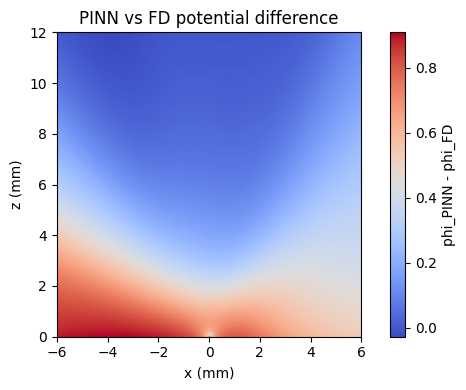

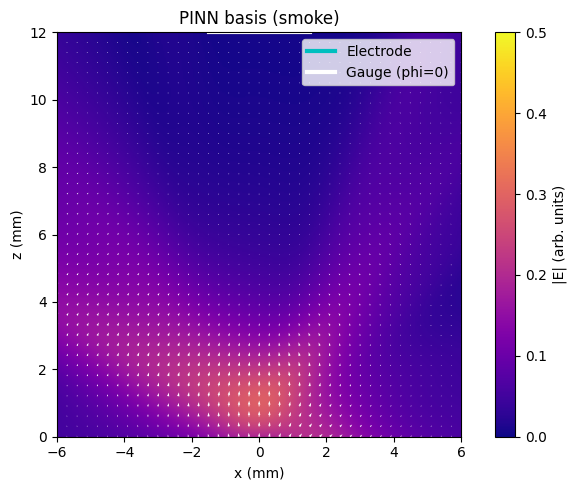

In [11]:
RUN_SMOKE = True
if RUN_SMOKE:
    smoke_center_mm = 0.0
    smoke_halfwidth_mm = contact_radius_mm
    smoke = train_pinn_basis(
        electrode_center_mm=smoke_center_mm,
        contact_halfwidth_mm=smoke_halfwidth_mm,
        interior_points=10_000,
        dirichlet_points=256,
        neumann_points=512,
        max_epochs=500,
        hidden_size=64,
        
    )
    phi_pinn, Ex_pinn, Ez_pinn, Emag_pinn = compute_field_from_model(smoke["model"])
    # Solve a matching finite-difference baseline for comparison
    fd_mask = make_bottom_mask(smoke_center_mm, smoke_halfwidth_mm)
    phi_fd = solve_laplace_fd(
        fd_mask,
        phi_electrode=smoke["problem"].phi_electrode,
        phi_gauge=smoke["problem"].phi_gauge,
        verbose=False,
    )
    compare_fd_to_pinn(phi_fd, phi_pinn)
    plot_field_map(Emag_pinn, Ex_pinn, Ez_pinn, title="PINN basis (smoke)", electrode_mask=electrode_mask, vmax=0.5)
else:
    print("Set RUN_SMOKE = True above to launch the PINN training demo.")
